/Users/zainhafeez/opt/anaconda3/lib/python3.9/site-packages/pennylane/ops/qubit/non_parametric_ops.py:2095: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(
/Users/zainhafeez/opt/anaconda3/lib/python3.9/site-packages/pennylane/ops/qubit/non_parametric_ops.py:2095: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


probabilities=[5.54667824e-32 5.54667824e-32 5.54667824e-32 1.00000000e+00]


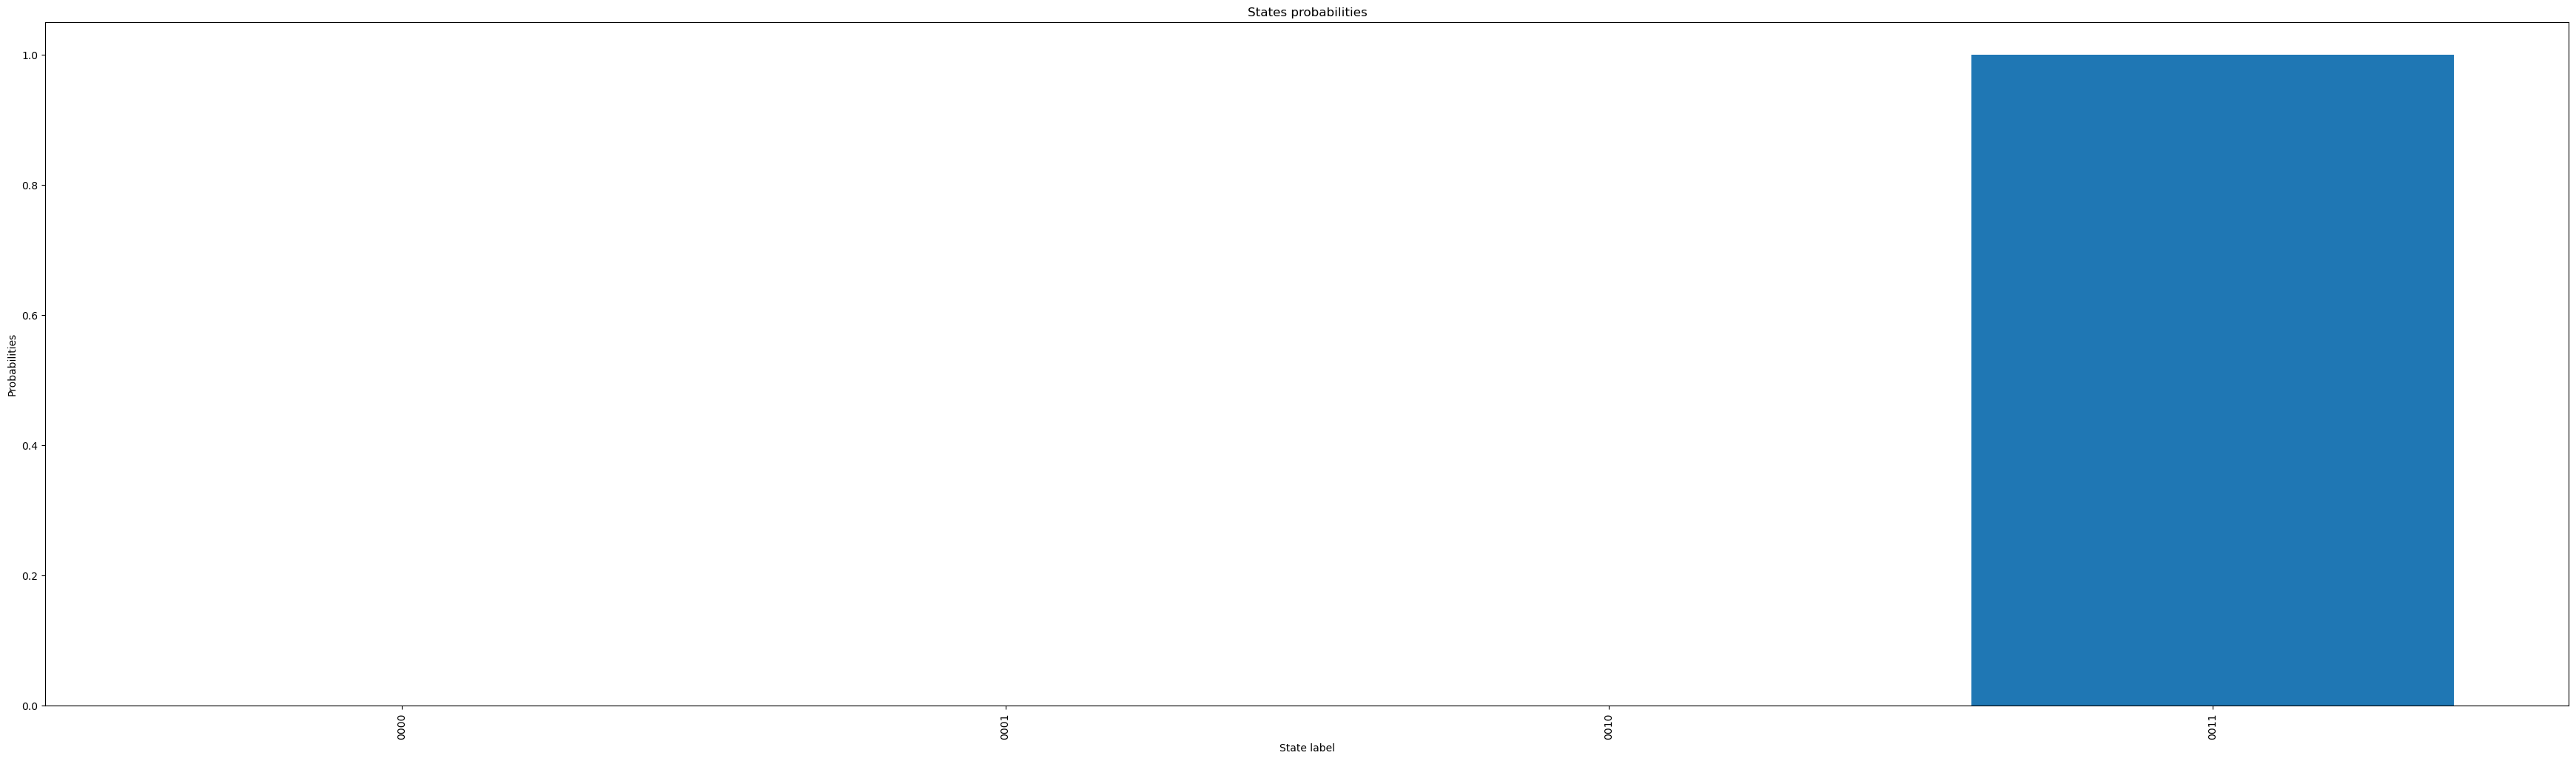

In [33]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

SCALES = 4
SCALES_QUBITS = int(np.ceil(np.log2(SCALES)))
MAX_BITS = 4
ENCODE_QUBITS = 2 * MAX_BITS

NUM_QUBITS = ENCODE_QUBITS + SCALES_QUBITS + 1

left_half = list(range(MAX_BITS))
right_half = list(range(MAX_BITS, 2*MAX_BITS))
encode_wires = list(range(2*MAX_BITS))
measured_wires = list(range(2*MAX_BITS, NUM_QUBITS-1))
aux_wires = NUM_QUBITS-1

device = qml.device("default.qubit", wires=NUM_QUBITS)
wires = list(range(NUM_QUBITS))

"""
Encodes a number into a binary string
"""
def binary(num, bits):
    return bin(num)[2:].zfill(bits)

"""
Applies X gates to qubits that needs to be flipped based on the binary bitstring
Left half is assigned qubits 0-3, right half 4-7
"""
def encode(x: str, isleft: bool):
    for i in range(len(x)):
        if x[i] == '1':
            # X-flip the desired qubit
            if isleft:
                qml.PauliX(wires=(i))
            else:
                qml.PauliX(wires=(i + MAX_BITS))

"""
Apply X-gate to qubits that were initially flipped based on saved data
"""
def reset(saved_bits):
    for i in range(len(saved_bits)):
        if saved_bits[i] == '1':
            qml.PauliX(wires=i)

"""
Implementation of oracle. Performs XOR on every corresponding bit on left and right
sums, and the result is used to control the multi-controlled gate on the aux gate
"""
def oracle(scale: int):
    # perform XOR on both left and right bits, stored in the right half bits
    for j in range(0,MAX_BITS):
        qml.CNOT(wires=[j, j+MAX_BITS])

    # connect controlled X gates to the ancilla (oracle)
    control = list(range(MAX_BITS, MAX_BITS*2)) + measured_wires
    qml.MultiControlledX(control_wires=control, wires=aux_wires, control_values="0000" + binary(scale, SCALES_QUBITS)[::-1])

    # reset the encoding qubits
    # swaps the right half qubits to original state
    for j in range(0,MAX_BITS):
        qml.CNOT(wires=[j, j+MAX_BITS])

@qml.qnode(device)
    
def circuit2(inputs):
      # grover init
      # put every measured state in superposition
    for i in measured_wires:
        qml.Hadamard(wires=i)
      # ancilla bit set to |-> state
    qml.PauliX(wires=aux_wires)
    qml.Hadamard(wires=aux_wires)

    # marks the qubits
    for _ in range(int(np.pi/4*np.sqrt(SCALES))):
        for i in range(len(inputs)):
            input = inputs[i]
            # sum the first half, get binary rep
        
            halfN = int(len(input) / 2)
            
            left = sum(input[:halfN])
            encode(binary(left, MAX_BITS), isleft=True)

            # sum the second half, get binary rep
            right = sum(input[halfN:])
            encode(binary(right, MAX_BITS), isleft=False)

            # get all the bits for qubit reset
            bits = binary(left, MAX_BITS) + binary(right, MAX_BITS)

            # implements oracle
            oracle(i)

            # resets the encoding qubits
            reset(bits)

        # Grover's iteration
        qml.GroverOperator(wires=measured_wires)

    # measure all the qubits that represent each scale, return the probs
    return qml.probs(wires=measured_wires)

if __name__ == "__main__":
    inputs = [[2,2,1,0,0,3],
[1,1,2,1,2,2],
[1,3,2,3,2,0],
[2,0,0,0,0,0,1,1]]

    qml.draw_mpl(circuit2)(inputs)
    plt.savefig("circuit_diagram2.png")

    probs = circuit2(inputs)
    print(f"probabilities={probs}")

    plt.clf()

    states = [format(i, f'0{SCALES}b') for i in range(SCALES)]

    plt.bar(states, probs)

    plt.xticks(rotation="vertical")
    plt.xlabel("State label")
    plt.ylabel("Probabilities")
    plt.title("States probabilities")
    plt.savefig("graph2.png")